dataset: https://drive.google.com/file/d/18aMf57_1u2AWInnMB67s3Xku0sPzm28u/view

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm


#for Data preprocessing and Augmentation
import os
from imutils import paths
import cv2
# import Augmentor
import torchvision.transforms as transforms

# from sklearn.preprocessing import OneHotEncoder

#for reading and displaying images
import matplotlib.pyplot as plt
from PIL import Image

#Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

#torchvision for pre-trained models
import torchvision
from torchvision import datasets, models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
# from sklearn.model_selection import KFold


# Setting

In [2]:
BATCH_SIZE = 32
classes = ['Normal', 'Covid']
num_classes = 2
num_epochs = 15
criterion = CrossEntropyLoss()
CHECKPOINT_PATH = './VGG19bn1.pt'
path_dataset = '/media/trucloan/Data/Research/TransferLearningVGG19bnCovid19/dataset10K_images/'

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Path dataset

In [3]:
normal = path_dataset + 'NORMAL/'
covid = path_dataset + 'COVID/'

dir_normal = os.listdir(normal)
dir_covid = os.listdir(covid)

# dataset = np.concatenate(dir_normal, dir_covid, axis = 0)
# dataset
dict_data0 = {'path': normal, 'image_name': dir_normal, 'labels': 0}
dict_data1 = {'path': covid, 'image_name': dir_covid, 'labels': 1}

# len(dict_data['COVID'])


In [4]:
import pandas as pd

df0 = pd.DataFrame(dict_data0)
df1 = pd.DataFrame(dict_data1)
df = pd.concat([df0, df1])
df.to_csv('./data.csv', index = False)

# Image Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        10000 non-null  object
 1   image_name  10000 non-null  object
 2   labels      10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [6]:
train_data, test_data=train_test_split(df, test_size=0.2, random_state = 42, shuffle=True)
train_data, val_data =train_test_split(train_data, test_size=0.2, random_state = 42, shuffle=True)

In [7]:
print(len(train_data), len(val_data), len(test_data))

6400 1600 2000


In [8]:
class ImageDataset(Dataset):
    def __init__(self, csv, transform):
        self.transform = transform
        self.csv = csv
        
        self.image_name = self.csv[:]['image_name']
        self.label = np.array(self.csv[:]['labels'])
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index): 
        images = Image.open(self.csv['path'].iloc[index] + self.image_name.iloc[index]).convert('RGB')
        
        images = self.transform(images)
        targets = self.label[index]
        targets = torch.tensor(targets, dtype = torch.long)
#         sample = {'image': image, 'labels': targets}
        
        return images, targets
        

In [9]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageDataset(train_data, transform)
val_dataset = ImageDataset(val_data, transform)
test_dataset = ImageDataset(test_data, transform)

train_dataset

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

# Build the models

# Using Transfer Learning

In [11]:
# loading the pretrained model
model = models.vgg19_bn(pretrained = True)
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [12]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Remove the pre-trained network's final layers

In [13]:
model.classifier[6] = Linear(4096, num_classes)

In [14]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Define  Train the Model using Early Stopping

In [15]:
def training_loop(model, optimizer, loss_list, acc_list):
    model.to(device)
    #List to store loss to visualize
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
    count = 0
    patience = 8 # nếu val_loss tăng 15 lần thì ngừng
    for epoch in range(num_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for data, label in tqdm(train_dataloader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(label).sum().item()
            
#         scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for data, label in tqdm(val_dataloader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(label).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, './VGG19_model.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
   
                return lossli, accli    
           
    return lossli, accli

In [16]:
#Create the optimizer
params_to_update = model.parameters()
print('Params to learn:')
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t Yes',name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print('\t No',name)
            
optimizer = Adam(params_to_update ,lr = 0.001, weight_decay=1e-5)
# scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones = [20, 35], gamma=0.1, last_epoch=-1, verbose=False)

Params to learn:
	 Yes features.0.weight
	 Yes features.0.bias
	 Yes features.1.weight
	 Yes features.1.bias
	 Yes features.3.weight
	 Yes features.3.bias
	 Yes features.4.weight
	 Yes features.4.bias
	 Yes features.7.weight
	 Yes features.7.bias
	 Yes features.8.weight
	 Yes features.8.bias
	 Yes features.10.weight
	 Yes features.10.bias
	 Yes features.11.weight
	 Yes features.11.bias
	 Yes features.14.weight
	 Yes features.14.bias
	 Yes features.15.weight
	 Yes features.15.bias
	 Yes features.17.weight
	 Yes features.17.bias
	 Yes features.18.weight
	 Yes features.18.bias
	 Yes features.20.weight
	 Yes features.20.bias
	 Yes features.21.weight
	 Yes features.21.bias
	 Yes features.23.weight
	 Yes features.23.bias
	 Yes features.24.weight
	 Yes features.24.bias
	 Yes features.27.weight
	 Yes features.27.bias
	 Yes features.28.weight
	 Yes features.28.bias
	 Yes features.30.weight
	 Yes features.30.bias
	 Yes features.31.weight
	 Yes features.31.bias
	 Yes features.33.weight
	 Yes feat

# Train the Model

In [17]:
loss_list, acc_list = [],[]

since = time.time()

loss, acc = training_loop(
    model = model,
    optimizer = optimizer,
    loss_list = loss_list,
    acc_list = acc_list
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch: 0 	Training Loss: 0.346536 	Validation Loss: 1.298258 	Training Acc: 88.281250 	Validation Acc: 75.750000
Validation loss decreased (inf --> 1.298258). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch: 1 	Training Loss: 0.232372 	Validation Loss: 0.509339 	Training Acc: 91.578125 	Validation Acc: 91.875000
Validation loss decreased (1.298258 --> 0.509339). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 2 	Training Loss: 0.179801 	Validation Loss: 0.163910 	Training Acc: 92.687500 	Validation Acc: 93.250000
Validation loss decreased (0.509339 --> 0.163910). Saving model ...
count =  0


100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


Epoch: 3 	Training Loss: 0.169673 	Validation Loss: 0.226174 	Training Acc: 93.500000 	Validation Acc: 91.000000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch: 4 	Training Loss: 0.130714 	Validation Loss: 0.201692 	Training Acc: 94.765625 	Validation Acc: 93.000000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 5 	Training Loss: 0.121056 	Validation Loss: 0.111347 	Training Acc: 95.093750 	Validation Acc: 96.187500
Validation loss decreased (0.163910 --> 0.111347). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 6 	Training Loss: 0.098537 	Validation Loss: 0.103188 	Training Acc: 96.546875 	Validation Acc: 95.875000
Validation loss decreased (0.111347 --> 0.103188). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch: 7 	Training Loss: 0.136442 	Validation Loss: 0.180787 	Training Acc: 95.046875 	Validation Acc: 94.312500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


Epoch: 8 	Training Loss: 0.101587 	Validation Loss: 0.215641 	Training Acc: 96.187500 	Validation Acc: 93.687500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Epoch: 9 	Training Loss: 0.107972 	Validation Loss: 0.195024 	Training Acc: 96.140625 	Validation Acc: 94.187500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  3


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


Epoch: 10 	Training Loss: 0.153669 	Validation Loss: 0.127508 	Training Acc: 95.031250 	Validation Acc: 95.437500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  4


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


Epoch: 11 	Training Loss: 0.094818 	Validation Loss: 0.142612 	Training Acc: 96.500000 	Validation Acc: 95.375000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  5


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Epoch: 12 	Training Loss: 0.070561 	Validation Loss: 0.086098 	Training Acc: 97.406250 	Validation Acc: 97.187500
Validation loss decreased (0.103188 --> 0.086098). Saving model ...
count =  0


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Epoch: 13 	Training Loss: 0.052392 	Validation Loss: 0.294835 	Training Acc: 98.078125 	Validation Acc: 96.125000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


Epoch: 14 	Training Loss: 0.053599 	Validation Loss: 0.085439 	Training Acc: 98.171875 	Validation Acc: 97.312500
Validation loss decreased (0.086098 --> 0.085439). Saving model ...
count =  0
Training complete in 53m 2s


# load model, state_dict

In [18]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


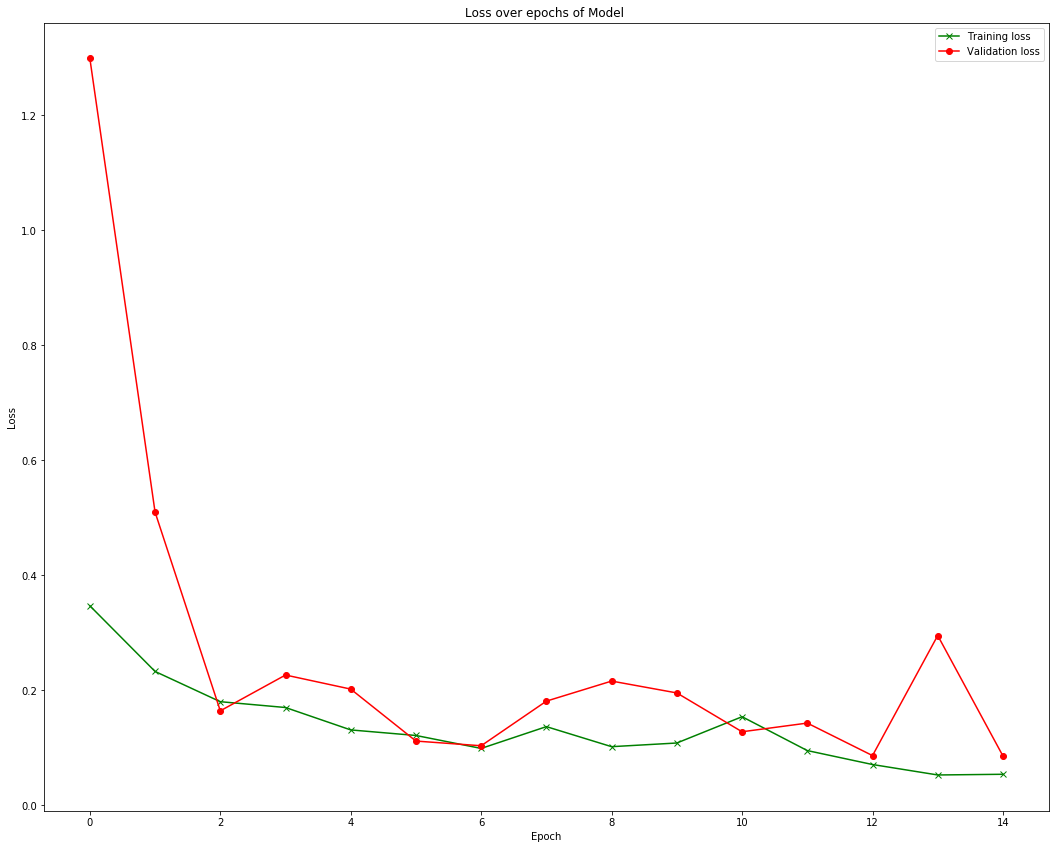

In [19]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, './lossVGG19.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


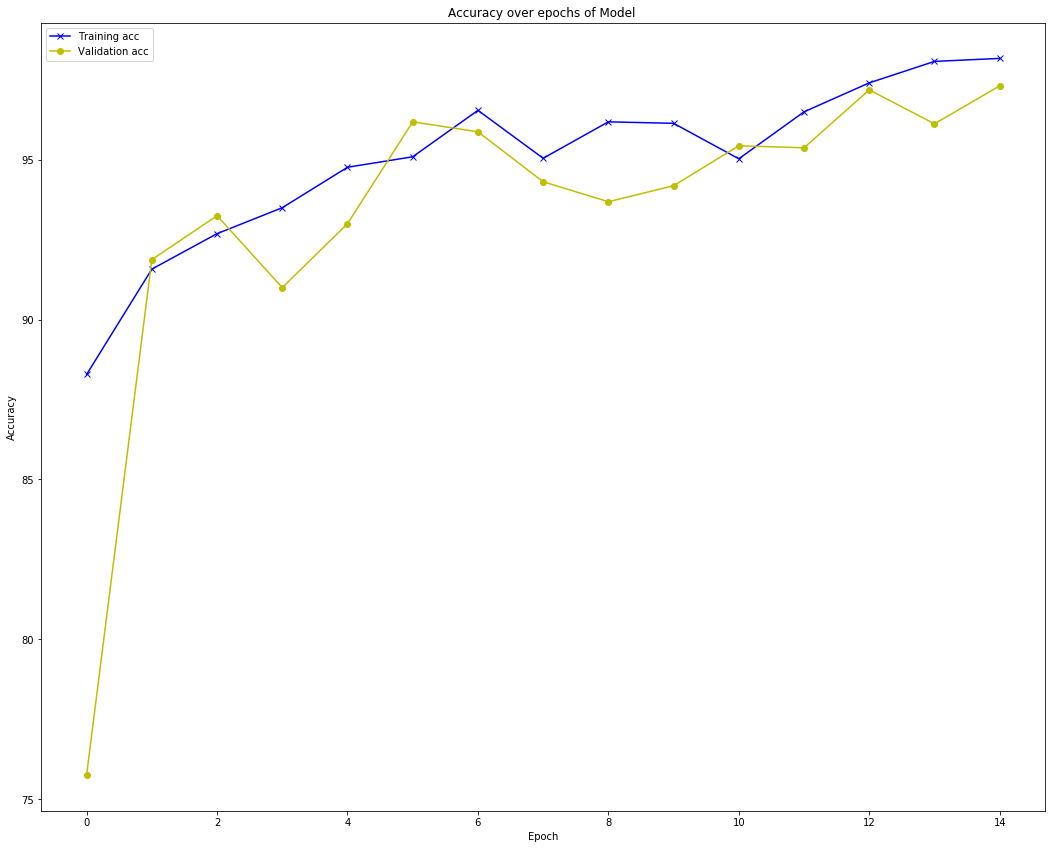

In [20]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, './AccuracyVGG19.png')

In [21]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model.to(device)
        model.eval()
        for data, target in test_dataloader:
            batch_size = data.size(0)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [22]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.9725

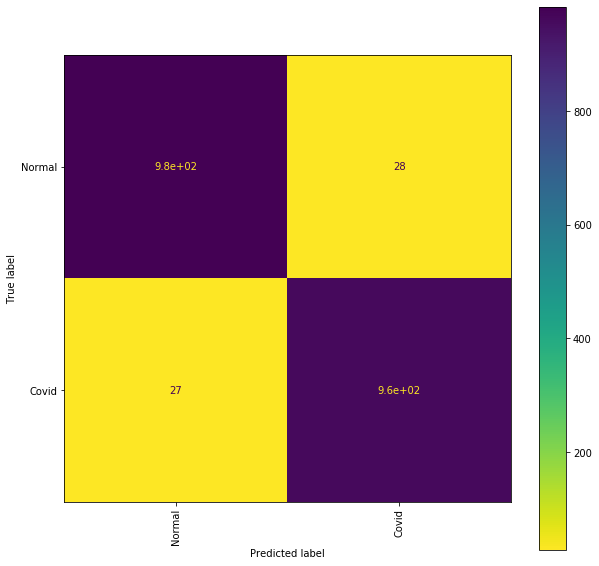

In [23]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'viridis_r', ax = ax, xticks_rotation = 'vertical')
plt.savefig('MatrixFTVGG19.png')

In [24]:
path_rp = './report_VGG19bn.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      1012
       Covid       0.97      0.97      0.97       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [28]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        pass
    model.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Negative')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Positive')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

img: covid.jpg is: Positive


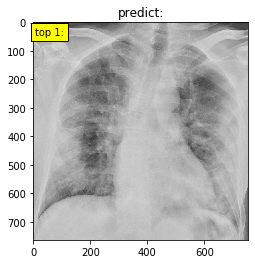

In [29]:
pred_str = str('')
path_image = './pred/covid.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()